# Required files

In [1]:
library(dplyr)
library(reshape2)
library(ggplot2)
library(corrplot)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

corrplot 0.84 loaded


# Loading required data

In [2]:
train1 = read.csv("Task1B_train.csv",header=TRUE)
test1 = read.csv("Task1B_test.csv",header=TRUE)

train.data <- as.data.frame(train1[, -5])
train.label <- as.data.frame(train1[, 5])
test.data <- as.data.frame(test1[, -5])
test.label <- as.data.frame(test1[, 5])

names(train.label)[1]<-paste("y")
names(test.label)[1]<-paste("y")

## KNN regression

In [3]:
avg <- function(x) {
    round(mean(x),digits=3)
}

# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    ## count number of train samples
    train.len <- nrow(train.data)
    
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    test.label = double(0)
    ## for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        ###... and calculate the predicted labels according to the majority vote
        test.label[i]<- (avg(train.label[nn]))
    }
    ## return the class labels as output
    return (test.label)
}


# Bootstrapping

In [4]:
# define a function that generates sample indixes based on bootstrap technique
boot <- function (original.size=100, sample.size=original.size, times=100){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}


In [10]:
# fix the parameters (50,40,50)
K <- 20           # Maximum K for KNN 
L <- 100           # number of datasets
N <- 25          # size of datasets

# generate bootstrap indices:
boot.indx <- boot(nrow(train.data), N, L)

# a dataframe to track the number of missclassified samples in each case
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

# THIS MAY TAKE A FEW MINUTES TO COMPLETE
## for every k values:
for (k in 1: K){
    
    ### for every dataset sizes:
    for (l in 1:L){
        
        #### calculate iteration index j
        j <- (k-1)*L+l
        
        #### save sample indices that were selected by bootstrap
        indx <- boot.indx[l,]
        
        #### save the value of k and l
        miss[j,'K'] <- k
        miss[j,'L'] <- l
        #### calculate and record the train and test missclassification rates
        miss[j,'test'] <-  sum((knn(train.data[indx, ], train.label[indx,], test.data, K=k)  - test.label)^2)/nrow(test.data)*100
    } 
}

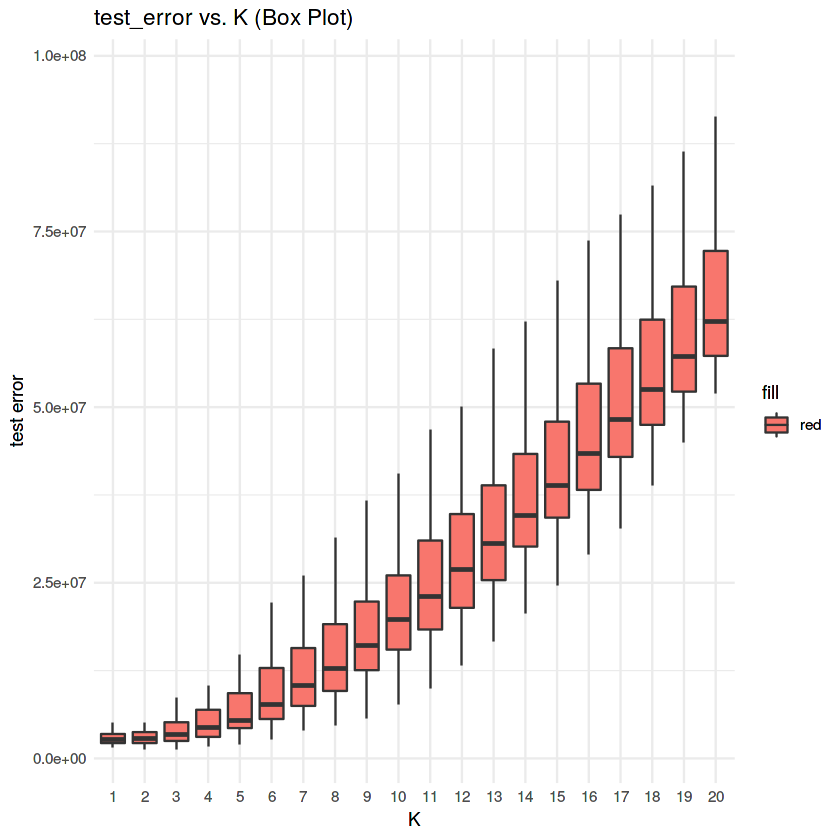

In [22]:
## plotting using ggplots
ggplot(data=miss, aes(factor(K), test,fill='red')) + geom_boxplot(outlier.shape = NA)+labs(y='test error', x = "K")  + 
  ggtitle('test_error vs. K (Box Plot)') + theme_minimal() 
# ignore the warnings (because of ignoring outliers)
options(warn=-1)


** As the K value increases the test error increases with its uncertainty**

In [67]:
# initialzing with required parameters 
L <- seq(10,200,by=10)
N <- 25
K <- 10
# creating empty dataframe
final_df = matrix(ncol=3)
colnames(final_df) <- c('L','N','test')
# for every L times
for ( i in L){
    # generate bootstrap indices:
    boot.indx <- boot(nrow(train.data), N, i)
    # a dataframe to track the number of missclassified samples in each case
    miss <- data.frame('L'=i, 'N'=1:i, 'test'=rep(0,i))
    # for each data sample
    for (l in 1:i){
        #### save sample indices that were selected by bootstrap
        indx <- boot.indx[l,]
        
        #### save the value of k and l
        miss[l,'L'] <- i
        miss[l,'N'] <- l
        #### calculate and record the train and test missclassification rates
        miss[l,'test'] <- sum((knn(train.data[indx, ], train.label[indx,], test.data, K=K)  - test.label)^2)/nrow(test.data)*100
    } 
    final_df <- rbind(data.frame(final_df),miss)
}
# preprocessing to create final dataframe
final_df <- final_df[2:nrow(final_df),]
rownames(final_df) <- seq(length=nrow(final_df)) 



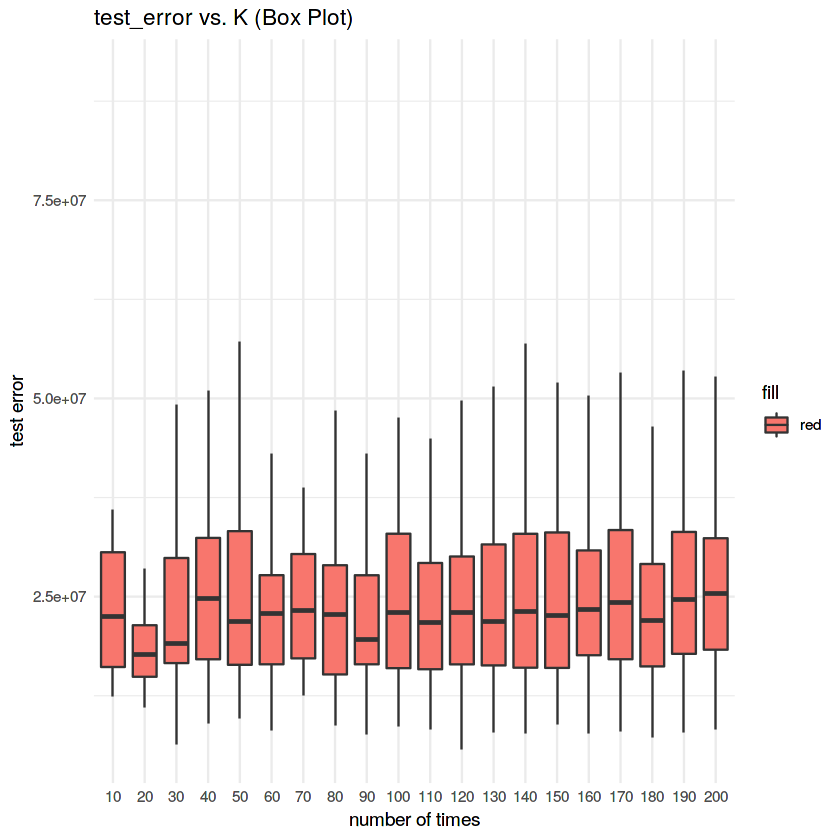

In [69]:
# plotting using ggplots
ggplot(data=final_df, aes(factor(L), test,fill='red')) + geom_boxplot(outlier.shape = NA)+labs(y='test error', x = "number of times")  + 
  ggtitle('test_error vs. K (Box Plot)') + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

** test error is so uncertain has number of subsets in bootstrapping increases.**